# Project : LCA with python

I wiill preform an LCA on the production and use phases of two types of electric machines, based on the impact category of global warming potential. 

After that, a contribution analysis should be conducted, as well as visualising the results.

# 1. Setting Up 
Here we need proper packages, databases to conduct LCA. We will conduct three steps which are  


(1) Importing relevant packages, 

(2) Ecoinvent database

(3) Create a database for the product (based on the excel file)

### 1-1. Importing the Relevant packages

In [1]:
# import the packages
import bw2data as bd # the data handling brightway package
import bw2io as bi # the data input out package, used to import ecoinvent
import bw2calc as bc # the package that does the math
import bw2analyzer as bwa # used for the iterative calculations
from brightway2 import *

# Impport basic libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

In [2]:
bd.projects.set_current("myproject")
bd.databases

Databases dictionary with 5 object(s):
	DB_Name
	Electric Machines
	biosphere3
	ecoinvent 3.9 cutoff
	ecoinvent 3.91 cutoff

### 1-2. Importing Ecoinvent Database

In [4]:
path = r"C:\Users\User\Song\ecoinvent 3.9.1_cutoff_ecoSpold02\datasets"
ei = SingleOutputEcospold2Importer(path, "ecoinvent 3.91 cutoff")
ei.apply_strategies()
ei.write_database()

Extracting ecospold2 files:
0% [##############################] 100% | ETA: 00:00:00 | Item ID: fffede58-fed2-5
Total time elapsed: 00:06:06


Title: Extracting ecospold2 files:
  Started: 05/27/2024 13:30:58
  Finished: 05/27/2024 13:37:05
  Total time elapsed: 00:06:06
  CPU %: 13.10
  Memory %: 20.64
Extracted 21238 datasets in 368.26 seconds
Applying strategy: normalize_units
Applying strategy: update_ecoinvent_locations
Applying strategy: remove_zero_amount_coproducts
Applying strategy: remove_zero_amount_inputs_with_no_activity
Applying strategy: remove_unnamed_parameters
Applying strategy: es2_assign_only_product_with_amount_as_reference_product
Applying strategy: assign_single_product_as_activity
Applying strategy: create_composite_code
Applying strategy: drop_unspecified_subcategories
Applying strategy: fix_ecoinvent_flows_pre35
Applying strategy: drop_temporary_outdated_biosphere_flows
Applying strategy: link_biosphere_by_flow_uuid
Applying strategy: link_internal_technosphere_by_composite_code
Applying strategy: delete_exchanges_missing_activity
Applying strategy: delete_ghost_exchanges
Applying strategy: remove_un

Writing activities to SQLite3 database:
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:41


Title: Writing activities to SQLite3 database:
  Started: 05/27/2024 13:37:15
  Finished: 05/27/2024 13:37:56
  Total time elapsed: 00:00:41
  CPU %: 43.00
  Memory %: 21.55
Created database: ecoinvent 3.91 cutoff


Brightway2 SQLiteBackend: ecoinvent 3.91 cutoff

### 1-3. Importing LCI data

Bring your Inventory data
Then use this codes so your inventory will be linked to ecoinvent data and biosphere.

In [25]:
# Import the excel LCI for a NMC cells
filepath = r"./LCI_Example.xlsx" # path to excel LCI
em_importer = bi.ExcelImporter(filepath) # create importer object

# Check for empty cells in Excel and remove (thanks to Romain Sacchi)
for x in em_importer.data:
        for k, v in list(x.items()):
            if not v:
                del x[k]

em_importer.apply_strategies() # apply strategies to process the excel data

# we link imported activities to one another first, if needed
# on the basis of their name, unit and location
em_importer.match_database(fields=["name", "unit", "location"])

# then we link to ecoinvent for the remaining unlinked technosphere exchanges
# on the basis of their name, reference product, unit and location
em_importer.match_database('ecoinvent 3.91 cutoff',  fields=["reference product", "name", "unit", "location"])

# and then we link emission flows to the biosphere database
em_importer.match_database('biosphere3',  fields=["name", "unit", "categories"])

# shows stats about unlinked exchanged
em_importer.statistics()

Extracted 1 worksheets in 0.01 seconds
Applying strategy: csv_restore_tuples
Applying strategy: csv_restore_booleans
Applying strategy: csv_numerize
Applying strategy: csv_drop_unknown
Applying strategy: csv_add_missing_exchanges_section
Applying strategy: normalize_units
Applying strategy: normalize_biosphere_categories
Applying strategy: normalize_biosphere_names
Applying strategy: strip_biosphere_exc_locations
Applying strategy: set_code_by_activity_hash
Applying strategy: link_iterable_by_fields
Applying strategy: assign_only_product_as_production
Applying strategy: link_technosphere_by_activity_hash
Applying strategy: drop_falsey_uncertainty_fields_but_keep_zeros
Applying strategy: convert_uncertainty_types_to_integers
Applying strategy: convert_activity_parameters_to_list
Applied 16 strategies in 5.28 seconds
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
2 datasets
4 exchanges
0 unlinked exchanges


(2, 4, 0)

In [26]:
em_importer.write_database()
bd.databases

Writing activities to SQLite3 database:
0% [##] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 05/27/2024 13:59:41
  Finished: 05/27/2024 13:59:41
  Total time elapsed: 00:00:00
  CPU %: 0.00
  Memory %: 22.77
Created database: DB_Name


Databases dictionary with 5 object(s):
	DB_Name
	Electric Machines
	biosphere3
	ecoinvent 3.9 cutoff
	ecoinvent 3.91 cutoff

In [27]:
ems = bd.Database('DB_Name') #create object
list([act for act in ems])

['activity2' (unit, GLO, None), 'activity1' (unit, GLO, None)]

# 2. Selecting an Impact Category Method

Due to its common use, we chose to pick an LCA method from the "ReCiPe 2016 v1.03" library. There are many methods that calculate GWP, so we plot preliminary results on IPMSM machine production to compare the differences. In the end, we choose the method "ReCiPe 2016 v1.03, midpoint (I) no LT".

### 2-1. Check what method data is in here

In [28]:
# Assuming `bd.method` is a Brightway2 database object with methods
methods_data = []

# Loop over methods and collect data
for method in bd.methods:
    method_data = bd.Method(method).load()  # This loads the method data
    methods_data.append({
        'name': method[0],
        'category': method[1],
        'description': method[2],
        'data': method_data
    })

# Now, convert the list of dictionaries into a DataFrame
df = pd.DataFrame(methods_data)
print(df)
# This DataFrame will have the method names, categories, descriptions, and the actual method data.

# Define the file path for the Excel file
excel_path = r'C:\Users\User\Song\data.xlsx'

# Export the DataFrame to an Excel file
df.to_excel(excel_path, index=False)

# Inform the user of the file path
#print(f"DataFrame has been exported to {excel_path}")

                    name                        category  \
0    CML v4.8 2016 no LT             acidification no LT   
1    CML v4.8 2016 no LT            climate change no LT   
2    CML v4.8 2016 no LT   ecotoxicity: freshwater no LT   
3    CML v4.8 2016 no LT       ecotoxicity: marine no LT   
4    CML v4.8 2016 no LT  ecotoxicity: terrestrial no LT   
..                   ...                             ...   
757              EN15804   inventory indicators ISO21930   
758              EN15804   inventory indicators ISO21930   
759              EN15804   inventory indicators ISO21930   
760              EN15804   inventory indicators ISO21930   
761              EN15804   inventory indicators ISO21930   

                                           description  \
0    acidification (incl. fate, average Europe tota...   
1              global warming potential (GWP100) no LT   
2     freshwater aquatic ecotoxicity (FAETP inf) no LT   
3         marine aquatic ecotoxicity (MAETP inf

### 2-2. Choose proper method

In [29]:
#Select Method
us_meth=[met for met in bd.methods if 'ReCiPe 2016 v1.03' in met[0] and
        'climate change' in met[1]]
# We take just the element of the list, instead of the list object, to make further calculations easier
lca_method = us_meth
print(lca_method)

[('ReCiPe 2016 v1.03, midpoint (E) no LT', 'climate change no LT', 'global warming potential (GWP1000) no LT'), ('ReCiPe 2016 v1.03, midpoint (E)', 'climate change', 'global warming potential (GWP1000)'), ('ReCiPe 2016 v1.03, midpoint (H) no LT', 'climate change no LT', 'global warming potential (GWP1000) no LT'), ('ReCiPe 2016 v1.03, midpoint (H)', 'climate change', 'global warming potential (GWP1000)'), ('ReCiPe 2016 v1.03, midpoint (I) no LT', 'climate change no LT', 'global warming potential (GWP1000) no LT'), ('ReCiPe 2016 v1.03, midpoint (I)', 'climate change', 'global warming potential (GWP1000)')]


In [34]:
# Seperating the production and use activities 
act1 = ems.search('activity1')[0]
print(act1)
act2= ems.search('activity2')[0]
print(act2)

'activity1' (unit, GLO, None)
'activity2' (unit, GLO, None)


# 3. Conduct LCA

In [39]:
result = []
for method in us_meth:
    # perform lca for nmc cells at pack level
    lca = bc.LCA({act1:1}, method)
    lca.lci()
    lca.lcia()
    
    # Show the output
    print("The {} process accounts for {:f} {}.".format(
        act1['name'],
        lca.score,
        bd.methods.get(method).get('unit')
        ))
    # Create a result dict
    if '(E)' in method[0]:
        midpoint='E'
    elif '(H)' in method[0]:
        midpoint='H'
    elif '(I)' in method[0]:
        midpoint='I'

    if 'no LT' in method[0]:
        midpoint = midpoint + ' no LT'
    else:
        midpoint = midpoint + ' with LT'
    result.append({'name' : act1['name'],
                   'Score':lca.score,
                   'Midpoint':midpoint,
                   'unit':bd.methods.get(method).get('unit')})

result_df1 = pd.DataFrame(result)

The activity1 process accounts for 276138.940314 kg CO2-Eq.
The activity1 process accounts for 276138.954819 kg CO2-Eq.
The activity1 process accounts for 300524.249722 kg CO2-Eq.
The activity1 process accounts for 300524.290759 kg CO2-Eq.
The activity1 process accounts for 340570.442602 kg CO2-Eq.
The activity1 process accounts for 340570.479524 kg CO2-Eq.


In [40]:
result = []
for method in us_meth:
    # perform lca for nmc cells at pack level
    lca = bc.LCA({act2:1}, method)
    lca.lci()
    lca.lcia()
    
    # Show the output
    print("The {} process accounts for {:f} {}.".format(
        act2['name'],
        lca.score,
        bd.methods.get(method).get('unit')
        ))
    # Create a result dict
    if '(E)' in method[0]:
        midpoint='E'
    elif '(H)' in method[0]:
        midpoint='H'
    elif '(I)' in method[0]:
        midpoint='I'

    if 'no LT' in method[0]:
        midpoint = midpoint + ' no LT'
    else:
        midpoint = midpoint + ' with LT'
    result.append({'name' : act2['name'],
                   'Score':lca.score,
                   'Midpoint':midpoint,
                   'unit':bd.methods.get(method).get('unit')})

result_df2 = pd.DataFrame(result)

The activity2 process accounts for 106.162004 kg CO2-Eq.
The activity2 process accounts for 106.162011 kg CO2-Eq.
The activity2 process accounts for 117.278973 kg CO2-Eq.
The activity2 process accounts for 117.278989 kg CO2-Eq.
The activity2 process accounts for 135.572075 kg CO2-Eq.
The activity2 process accounts for 135.572090 kg CO2-Eq.


<function matplotlib.pyplot.show(close=None, block=None)>

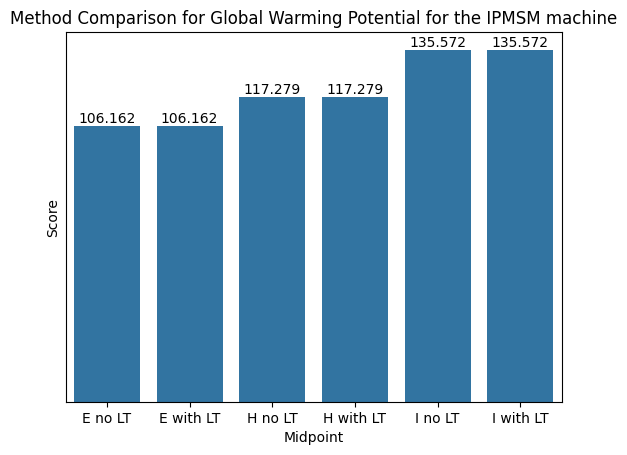

In [38]:
# Plot the results
ax=sns.barplot(data=result_df, x='Midpoint', y='Score')
ax.bar_label(ax.containers[0], fontsize=10);
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    labelleft=False)        # ticks along the top edge are off
plt.title('Method Comparison for Global Warming Potential for the IPMSM machine')
plt.show